## Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import random
import tensorflow
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
from zipfile import ZipFile

data_path = "/content/myData.zip"
labels_path = "/content/labels.zip"

with ZipFile(labels_path,'r') as zip_ref:
  zip_ref.extractall('/tmp/TRAFFIC_DATA')
  zip_ref.close()

In [ ]:
with ZipFile(data_path,'r') as zip_ref:
  zip_ref.extractall('/tmp/TRAFFIC_DATA')
  zip_ref.close()

## Data Loading

In [ ]:
DATASET = "/tmp/TRAFFIC_DATA/myData"
LABELS = "/tmp/TRAFFIC_DATA/labels.csv"

count = 0
images = []
classNo = []
totalClasses = len(os.listdir(DATASET))

for i in range(0,totalClasses):
  path = os.path.join(DATASET,str(i))
  for img in os.listdir(path):
    img_path = os.path.join(path, img)
    curImage = cv2.imread(img_path)
    images.append(curImage)
    classNo.append(i)

images = np.array(images)
classNo = np.array(classNo)

## Data Splitting

In [ ]:
# Creating test data
X_train, X_test,y_train, y_test = train_test_split(images,classNo,test_size = 0.2)
# Creating train and validation data
X_train, X_validation, y_train, y_validation = train_test_split(X_train,y_train, test_size = 0.2)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"X_validation shape: {X_validation.shape}")
print(f"y_validation shape: {y_validation.shape}")

X_train shape: (22271, 32, 32, 3)
y_train shape: (22271,)
X_test shape: (6960, 32, 32, 3)
y_test shape: (6960,)
X_validation shape: (5568, 32, 32, 3)
y_validation shape: (5568,)


In [ ]:
labelData=pd.read_csv(LABELS)
print("labelData shape ",labelData.shape)

labelData shape  (43, 2)


In [ ]:
labelData.head()

,ClassId,Name
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


## Data Visualization

In [ ]:
def viz():
  plt.figure(figsize=(10,10))
  for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(X_train[i],cmap='binary')
      plt.title(labelData.Name[y_train[i]])
  plt.show()

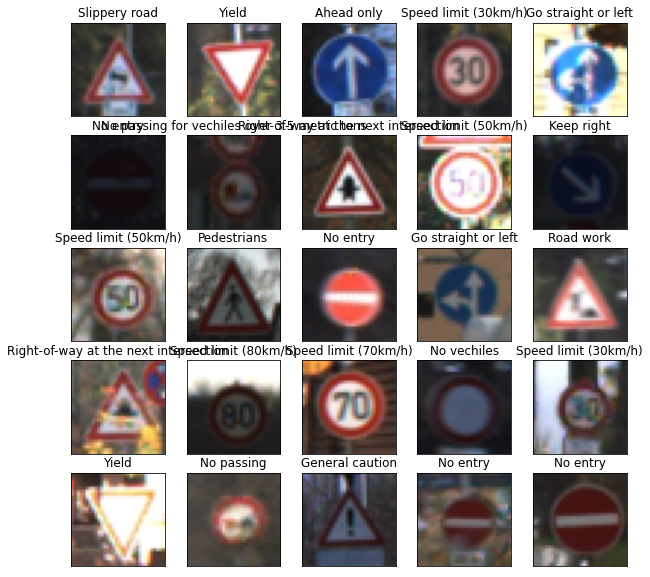

In [ ]:
viz()

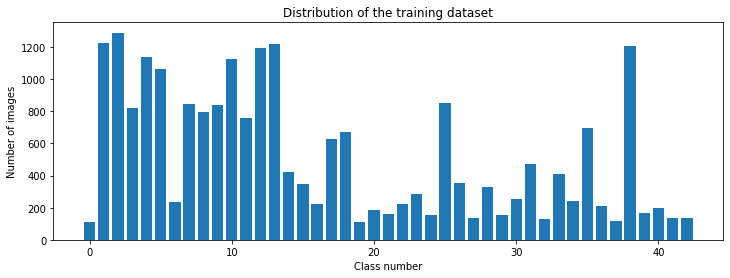

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(12, 4))
plt.bar(range(0,labelData.shape[0]),counts)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

### Data Preprocessing

## DATA AFTER PREPROCESSING ##


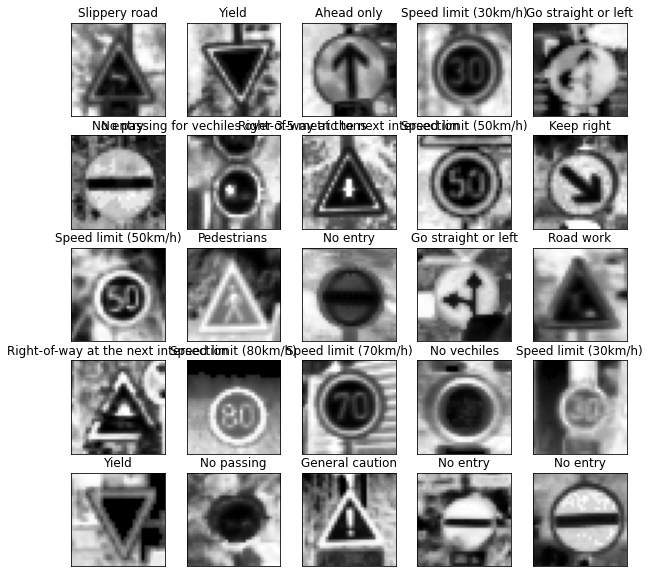

X_train shape: (22271, 32, 32, 1)
X_test shape: (6960, 32, 32, 1)
X_validation shape: (5568, 32, 32, 1)


In [ ]:
def grayscale(img):
  return cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

def equilize(img):
  return cv2.equalizeHist(img)

def preprocessing(img):
  img = grayscale(img)
  img = equilize(img)
  img = img/255.
  return img

X_train = np.array(list(map(preprocessing,X_train)))
X_test = np.array(list(map(preprocessing,X_test)))
X_validation = np.array(list(map(preprocessing,X_validation)))

print("## DATA AFTER PREPROCESSING ##")
viz()

X_train = X_train.reshape(*X_train.shape,1)
X_test = X_test.reshape(*X_test.shape,1)
X_validation = X_validation.reshape(*X_validation.shape,1)


print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"X_validation shape: {X_validation.shape}")

y_train = to_categorical(y_train,totalClasses)
y_validation = to_categorical(y_validation,totalClasses)
y_test = to_categorical(y_test,totalClasses)

### Data Augmentation and Model Training

### Augment

In [ ]:
augment = ImageDataGenerator(rotation_range=10,
                             zoom_range=0.2,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             fill_mode="nearest")

augment.fit(X_train)

### Model Structure

In [ ]:
def create_model():
  input_ = Input(shape=(32,32,1))
  x = Conv2D(60,(5,5),activation='relu')(input_)
  x = Conv2D(60,(5,5),activation='relu')(x)
  x = MaxPooling2D((2,2))(x)
  x = Conv2D(30,(3,3),activation='relu')(x)
  x = Conv2D(30,(3,3),activation='relu')(x)
  x = MaxPooling2D((2,2))(x)
  x = Dropout(0.5)(x)
  x = Flatten()(x)
  x = Dense(500,activation='relu')(x)
  x = Dropout(0.5)(x)
  output_ = Dense(totalClasses,activation='softmax')(x)

  model = Model(input_,output_)
  return model

In [ ]:
LR = 1e-3
EPOCHS = 10
BATCH_SIZE = 50
opt = Adam(lr=LR)
# opt = Adam(lr=LR,decay=LR/EPOCHS)

model = create_model()
model.compile(loss = 'categorical_crossentropy',optimizer=opt,
              metrics=['accuracy'])

history = model.fit(augment.flow(X_train,y_train,batch_size=BATCH_SIZE),
                    steps_per_epoch=len(X_train)//BATCH_SIZE,
                    validation_data=(X_validation,y_validation),
                    epochs=EPOCHS,shuffle=1)

Epoch 1/10
445/445 [==============================] - 8s 18ms/step - loss: 2.7834 - accuracy: 0.2402 - val_loss: 0.9976 - val_accuracy: 0.7137
Epoch 2/10
445/445 [==============================] - 8s 17ms/step - loss: 1.3878 - accuracy: 0.5751 - val_loss: 0.4341 - val_accuracy: 0.8797
Epoch 3/10
445/445 [==============================] - 8s 18ms/step - loss: 0.9232 - accuracy: 0.7164 - val_loss: 0.2243 - val_accuracy: 0.9319
Epoch 4/10
445/445 [==============================] - 8s 18ms/step - loss: 0.6953 - accuracy: 0.7837 - val_loss: 0.1535 - val_accuracy: 0.9596
Epoch 5/10
445/445 [==============================] - 8s 17ms/step - loss: 0.5701 - accuracy: 0.8228 - val_loss: 0.1132 - val_accuracy: 0.9720
Epoch 6/10
445/445 [==============================] - 8s 17ms/step - loss: 0.4932 - accuracy: 0.8469 - val_loss: 0.0918 - val_accuracy: 0.9756
Epoch 7/10
445/445 [==============================] - 8s 17ms/step - loss: 0.4266 - accuracy: 0.8664 - val_loss: 0.0897 - val_accuracy: 0.9781

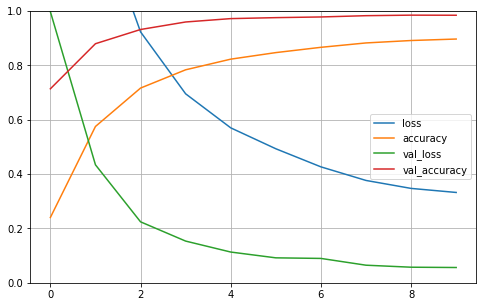

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) 
plt.show()

In [ ]:
model.evaluate(X_test,y_test)

218/218 [==============================] - 1s 4ms/step - loss: 0.0641 - accuracy: 0.9815


[0.0641164779663086, 0.9814655184745789]

43

In [ ]:
prediction = model.predict(X_test, batch_size=BATCH_SIZE)
prediction = np.argmax(prediction, axis=1)

# classification report
print(classification_report(y_test.argmax(axis=1), prediction))

# saving model
model.save("/tmp/traffic_sign_classfier.model",save_format="h5")

              precision    recall  f1-score   support

           0       1.00      0.72      0.84        36
           1       0.96      1.00      0.98       413
           2       0.99      0.97      0.98       388
           3       0.96      0.97      0.96       231
           4       0.99      0.99      0.99       352
           5       0.97      0.98      0.97       313
           6       0.97      1.00      0.99        68
           7       0.90      1.00      0.95       246
           8       0.98      0.93      0.96       256
           9       0.99      0.99      0.99       270
          10       1.00      0.99      1.00       368
          11       0.98      0.98      0.98       227
          12       1.00      0.99      1.00       386
          13       1.00      1.00      1.00       392
          14       1.00      1.00      1.00       156
          15       0.97      0.92      0.94       118
          16       0.99      1.00      0.99        68
          17       1.00    